## Lecture 4: Incomplete market models with transition dynamics

In this lecture, I introduce the basic set-up of the workhorse incomplete market model -- the Aiyagari model and discuss how to compute it numerically. When writing this lecture, I largely follow from my answer for problem set 3 and 4 for Manuel Amador's Macro class.

Useful notes: Jesus Fernandez-Villaverde's notes on heterogeneous agent models: [part 1](https://www.sas.upenn.edu/~jesusfv/Lecture_Heterogeneous_I.pdf), [part 2](https://www.sas.upenn.edu/~jesusfv/Lecture_Heterogeneous_II.pdf), [part 3](https://www.sas.upenn.edu/~jesusfv/Lecture_Heterogeneous_III.pdf).

### General set up of the Aiyagari model

#### Environment:

##### Household:

Continuum of household with mass 1:

Household has identical preferences: 
$$
\sum_{t=0}^\infty \beta^t u(c_t)
$$,

subject to a budget constraint: $c_t + a_{t+1} \leq w_t l_t(s^t) + R_t a_t, \forall t$,

and ***a borrowing limit: $a_{t + 1} \geq \phi, \forall t$***,

with $a_0, l_0 \geq 0$ given.

 <br>

Let labor endowments for ***each*** household follow a markov chain with a transition matrix $\pi$, $\pi(s'|s) > 0, \forall s, s'$. The invariant distribution of labor supply is a probability distribution $\lambda$ such that $\lambda \pi = \pi$. 

By law of large number, the aggregate labor supply  $L = \sum_{s \in S} \lambda(s) l(s)$ does not depend on $s$ (no aggregate uncertainty). This is a key feature of the problem.

<br>

##### Firm:

A perfectly competitive firm with Neo-classical technology:
$$
Y_t = F(K_t, L_t).
$$

##### Aggregate resource constraint:
$$
C_t + K_{t+1} - (1 - \delta) K_t = F(K_t, L)
$$
with depreciation rate $\delta \in (0,1)$.

### Recursive formulation of the household problem

Assume utility is strictly increasing. Taking the interest rate $R$ and $w$ as given, the household problem takes the recursive form:

$V(a, s) = \max_{a'\geq \phi} u(Ra + w l(s) - a') + \beta E[V(a', s')]$

where $s$ is the realization of the labor endowment today. 

#### Side notes on alternative specification of the household problem: 
*Alternatively we can write the problem as $V(x, s) = \max_{a'\geq \phi} u(x - a') + \beta E[V(Ra' + w l(s'), s')]$, where $x \equiv Ra + w l(s)$ is the cash in hand today. Note that the value function will be different as it is now a function of $x$. The key here is that one need to make sure that the state variables on both sides are consistent.*

*On top of this, Aiyagari used a trick to simplify the problem. Define $\hat{a} = a + \phi$, $\hat{x} = x + \phi$. Then, the household problem can be rewritten as:*

*$v(\hat{x}, s) = \max_{\hat{a}' \geq 0} u(\hat{x} - \hat{a}') + \beta E[v(R\hat{a}' + w l(s') - (R - 1) \phi), s']$*

<br>

Now let's try to solve the household problem using $a$ as the first state variable given particular $R$ and $w$. This is essentially a partial equilibrium and is often referred to as a Bewley/Hugget model.

### Computing the Bewley/Hugget Model

Note that here only the product of $w$ and $l$ matters here and there's no interesting mechanism for determining $w$. For simplicity, we define $y(s) \equiv wl(s)$ such that $V(a, s) = \max_{a'\geq \phi} u(Ra + y(s) - a') + \beta E[V(a', s')]$. Further assume $s$ follows a first-order markov chain governed by states $y(s)$ and transition matrix $P$.

We will construct grids using $a$. Let $a$ start from $\phi$ so the agent cannot over-borrow.

The following codes are adopted from problem set 2 and 3 from Manuel Amador's Macro class. 

As before, `Base.@kwdef struct` is used to store the parameters. However here instead of some specific types like `Float64`, we use parametric types like `R1` and `T1`. These can really be any types dependent on the input. Check the [documentation for parametric types](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types-1) here.

In [4]:
using LinearAlgebra
using Plots

In [274]:
Base.@kwdef struct Household{T1, T2, T3, R1, S}
    β::R1 = 0.95
    ρ::R1 = 2.0 
    ϕ::R1 = 0.0  # The borrowing limit is zero 
    P::T1 = [0.5 0.5; 0.2 0.8] # transition matrix for state s
    l::T2 = [0.5, 1.0] # labor endowment: l(s) (normalize w to 1.0 so that y(s) = l(s))
    a_min::R1 = ϕ
    a_max::R1 = 5.0
    points::S = 10_000
    
    a_grid::T3 = range(a_min, a_max, points)
end

u(c, m) = c ^ (1 - m.ρ) / (1 - m.ρ)  
uprime(c, m) = c ^ (-m.ρ) 

uprime (generic function with 1 method)

Now solve the value function as before. Since we have two states now, we need a matrix to store the value and policy for each different combination of $a$ and $y$.

There are mainly two tricks in the code. The first is to pre-compute the expected discounted value for each $a'$ and $s'$ conditional on $s$ within the outer loop. The second is to take use of the fact of strictly increasing policy function as we have seen in Lecture 2.

In [5]:
function solve_household(h; R = 0.9, w = 1.0, v0 = zeros(length(h.a_grid), length(h.l)),  tol = 1e-6)
    
    # unpacking 
    (; a_grid, l, β, P) = h
    
    v1 = similar(v0)
    pol = similar(v0, Int)
    βv = similar(v1)
    
    n = length(a_grid)
    
    iter = 0
    while true
        distance = zero(eltype(v0))
        iter += 1 
        
        # Precompute βE[V(a', s')] for better performance
        for s in eachindex(l)
            for i in eachindex(a_grid)
                accum = zero(eltype(v0))
                for sprime in eachindex(l)
                    accum += β * P[s, sprime] * v0[i, sprime]
                end
                βv[i, s] = accum
            end 
        end

        for s in eachindex(l) 
            pol_i = 1
            for i in eachindex(a_grid)
                just_started = true 
                vmax = zero(eltype(v0))
                for j in pol_i:n #take use of strictly increasing policy function
                    c = R * a_grid[i] + w*l[s] - a_grid[j]
                    if c > 0.0
                        v_tmp = u(c, h) + βv[j, s]
                        if just_started
                            vmax = v_tmp
                            pol_i = j
                            just_started = false
                        elseif v_tmp > vmax 
                            vmax = v_tmp 
                            pol_i = j
                        else 
                            break 
                        end 
                    end 
                end 
                v1[i, s] = vmax
                pol[i, s] = pol_i
                dis = abs(vmax - v0[i, s])
                if dis > distance
                    distance = dis
                end 
            end 
        end 
        
        if distance < tol
            break
        else 
            v0 .= v1
        end 
    end 
    return (v = v1, pol = pol, h = h, R = R, w = w)
end 
    

solve_household (generic function with 1 method)

Explanations over how the code works (GPT generated, which is actually pretty good): 

This function solve_household solves the household problem defined earlier using value function iteration. The function takes in the model parameters as input, par, and some optional arguments such as an initial guess for the value function v0 and a tolerance level tol.

The function initializes some variables such as v1 and pol as arrays of zeros with the same shape as v0, which is the value function from the previous iteration. βv is also initialized as an array of zeros, which will be used to store the expected value of the next iteration.

The function then performs the value function iteration using a nested loop over ytilde and ahat_grid. The inner loop first computes the expected value of the next iteration using the Bellman equation and stores it in βv. 

The inner loop then maximizes the Bellman equation over the choice of next period asset holding ahat_grid[j] using a nested loop that starts at pol_i. This is done to take advantage of the fact that the optimal choice of ahat_grid[j] is increasing in j. The loop computes the value of the Bellman equation for each ahat_grid[j] and stops once the first ahat_grid[j] is found that yields a negative consumption level c. The function then stores the optimal value function vmax and the corresponding choice of j in pol_i and moves on to the next ahat_grid[i].

The function then computes the distance between the value function from the current iteration v0 and the value function from the previous iteration v1. If the distance is less than the tolerance level tol, the function exits the loop and returns the value function v1, the policy function pol, and the model parameters m.

Overall, the function uses a nested loop to solve the household problem using value function iteration, and it takes advantage of the fact that the problem has a recursive structure and a simple functional form for the utility function to compute the optimal value and policy functions efficiently.

In [276]:
h = Household() # struct with default parameter values
sol_1 = solve_household(h, R = 0.658) #input some random R. 

(v = [-26.71326843693425 -25.314667038332857; -26.711953170852723 -25.314338113656607; … ; -24.019524603316466 -23.72455416253825; -24.019409824729976 -23.72445885993552], pol = [1 1; 1 1; … ; 4194 4864; 4194 4864], h = Household{Matrix{Float64}, Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}(0.95, 2.0, 0.0, [0.5 0.5; 0.2 0.8], [0.5, 1.0], 0.0, 5.0, 10000, 0.0:0.0005000500050005:5.0), R = 0.658, w = 1.0)

Let's take a look at the value function and policy functions

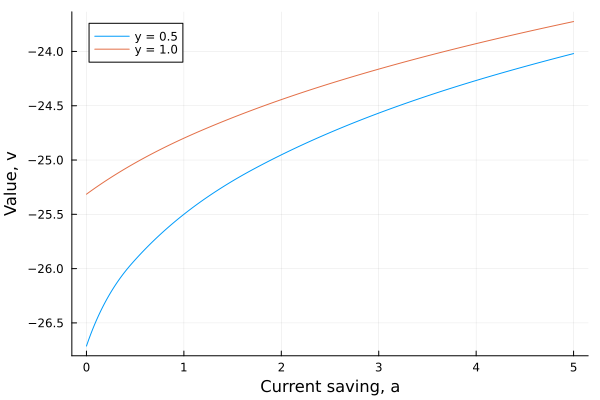

In [277]:
function do_v_plot(sol_1)

    income = sol_1.w * sol_1.h.l 
    p1 = Plots.plot(xlabel = "Current saving, a", ylabel = "Value, v")
    for i in eachindex(income)
        temp = income[i]
        plot!(p1, sol_1.h.a_grid, sol_1.v[:,i], label = "y = $temp")
    end
    
    return p1
end

do_v_plot(sol_1)

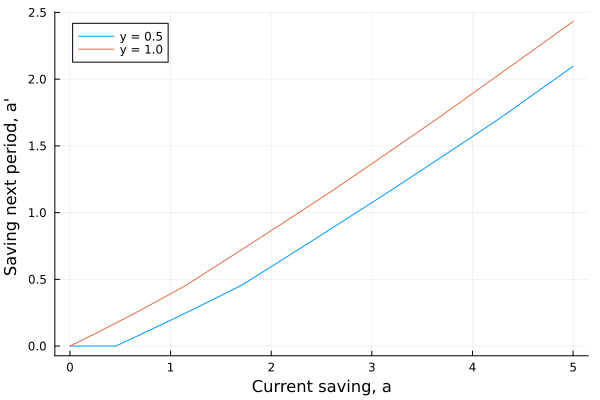

In [278]:
function do_pol_plot(sol_1)

    (; pol, h)= sol_1 

    p1 = Plots.plot(xlabel = "Current saving, a", ylabel = "Saving next period, a' ")
    for s in eachindex(h.l)
        temp = sol_1.w * h.l[s]
        yvals = [[h.a_grid[pol[i, s]] for i in eachindex(h.a_grid)]]
        plot!(p1, sol_1.h.a_grid, yvals, label = "y = $temp")
    end
    
    return p1
end

do_pol_plot(sol_1)

Note that when $y$ is low. The policy function for $a'$ is flat. The intuition is that the agent has incentive to borrow for consumption smoothing when endowment is low (why?) but is borrowing constrained due to the $0$ borrowing limit. As a result, the agent consumes all her endowment. This is sometimes referred to as "Hand-to-mouth" consumption.

### Recursive competitive equilibrium (Aiyagari 1994)

With some understanding of the partial equilibrium, we now try to build towards the general equilibrium. With household optimality, firm optimality and market clearing conditions, the equilibrium can be formally defined by a recursive competitive equilibrium.

The key difference is that every household now needs to know the distribution of everyone else's asset holdings to infer future interest rate. 

Let $a \in A \equiv [\phi, \infty]$, $s \in S$. From the recursive form of the household problem, for given R we can solve for a value function $v(a, s): A \times S \to R$ and a policy function for saving $g(a, s): A \times S \to A$. 



#### Prices in general equilibrium

Now for simplicity, let the firm technology be characterized by a CRS Cobb-Douglas production function, i.e.
$$
Y_t = A K_t^\alpha L_t^{1 - \alpha}.
$$

The firm's problem takes the form: (why?)

$$\max_{K_t, L_t} A K_t^\alpha L_t^{1 - \alpha} - (R_t -1 +\delta) K_t - w_t L_t$$

Firm's first order conditions:
$$
\begin{cases}
R_t = A \alpha K_t^{\alpha - 1} L_t^{1 - \alpha} +1 - \delta \\
w_t = A (1 - \alpha) K_t^\alpha L_t^{-\alpha}
\end{cases}
$$

Note that $w$ can be pinned down by $R$ in equilibrium:
$$
w_t(R_t) = A^{\frac{1}{1-\alpha}} (1 - \alpha) \alpha^{\frac{\alpha}{1 - \alpha}} \left(R_t - 1 +\delta \right)^{\frac{\alpha}{1 - \alpha}}
$$

This is very handy when it comes to computing the equilibrium prices. 

### Stationary Competitive Equilibrium

#### Set up of a (recursive) stationary competitive equilibrium

A stationary competitive equilibrium is defined by a system of constant prices (interest rate and wage) and allocations such that individuals optimize and markets clear.

Define $\lambda_t(a, s): A \times S \to [0,1]$ to be the distribution of household over current asset $a$ and state $s$. Imagine it to be a matrix with each entry filled with the fraction of household with each combination of possible $a$ and $s$. Hypothetically, this should evolve over time following a law of motion:
$$
\lambda_{t+1}(a', s') = \sum_{s \in S} \sum_{a: g(a,s) = a'} \pi(s'|s) \lambda_t(a,s), \quad \forall a', s'
$$

where $\pi(s'|s)$ is the transition probability and $\sum_{a: g(a,s) = a'}$ reads that all $a$ such that $g(a,s) = a'$. Intuitively, the fraction of households that falls into the state $a'$ and $s'$ next period will be the fraction of households (with different $a$ and $s$) that choose $a'$ times the conditional probability that the household moves into $s'$ next period. 

Does the economy converge to some kind of steady state (stationary equilibrium)? Here, in a stationary equilibrium, $\lambda_t = \lambda, \forall t$ and all aggregate real quantities and prices stay constant. Aiyari (1994) proved that under some conditions, with no aggregate shock, a stationary competitive equilibrium exists for the economy. For clarity, I will formally define the stationary competitive equilibrium as follows.

A ***stationary competitive equilibrium*** is scalars $\{R, w, K, L\}$ and functions $\{v, g, \lambda\}$ such that:

* The value function, $v$ satisfies the Household's problem given $R, w$ and $l(s)$, and $g$ is an optimal policy to the problem.
* $\lambda$ is the stationary distribution that arises from $g$ and $\pi$ (from above).
* Asset market clears, i.e. $K = \sum_{s \in S} \sum_{a \in A} \lambda(a,s) g(a,s)$.
* Labor market clears, i.e. $L = \sum_{s \in S} \sum_{a \in A} \lambda(a,s) l(s)$.
* Firm's optimality conditions are satisfied.

Good's market will clear with a Walras' Law-ish argument.

Now let's build towards computing the model. Add some more parameters in the struct.

In [106]:
Base.@kwdef struct Household_GE{T1, T2, T3, R1, S}
    β::R1 = 0.7
    ρ::R1 = 2.0 
    ϕ::R1 = 0.0  # The borrowing limit is zero 
    P::T1 = [0.5 0.5; 0.2 0.8] # transition matrix for state s
    l::T2 = [2.0, 4.0] # l(s)
    a_min::R1 = ϕ
    a_max::R1 = 5.0
    points::S = 10_000

    a_grid::T3 = range(a_min, a_max, points)

    A::R1 = 1.25
    α::R1 = 0.7
    δ::R1 = 1.0  #full depreciation
end

u(c, m) = c ^ (1 - m.ρ) / (1 - m.ρ)  
uprime(c, m) = c ^ (-m.ρ) 

uprime (generic function with 1 method)

In [107]:
h_GE = Household_GE()

Household_GE{Matrix{Float64}, Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}(0.7, 2.0, 0.0, [0.5 0.5; 0.2 0.8], [2.0, 4.0], 0.0, 5.0, 10000, 0.0:0.0005000500050005:5.0, 1.25, 0.7, 1.0)

It is useful to note that at stationary equilibrium, $L$ is a constant. This is because if you solve for the invariant distribution of $P$ (the transition probability $\pi$ ), $L$ can be written as $\sum_{s \in S} \pi(s) l(s)$.  Here we will numerically compute $L$.

In [108]:
function compute_L(P, l)
    # approximate the invariant distribution of labor endowment (inefficient)
    temp = P^100
    L = 0
    for i in eachindex(l)
        L = L + l[i] * temp[1,i] 
    end
    return L
end

compute_L(h_GE.P, h_GE.l)

3.428571428571446

First let's compute the invariant distribution given some $R$. For simplicity let $A$ be 1 (not the correct way if you want to calibrate the model). Since we want to include firm's optimality conditions, modify the function for computing $v$ to include firm's optimality condition. Now we have $K$ as input and then solve for $R$ and $w$ endogenously.

In [109]:
function solve_household_GE(h_GE; K = 0.5, v0 = zeros(length(h_GE.a_grid), length(h_GE.l)),  tol = 1e-7)
    
    # unpacking 
    (; a_grid, l, β, P, A, α, δ) = h_GE
    
    L = compute_L(P, l)

    R = A * α * K^(α - 1) * L^(1 - α) + 1 - δ# Get R from the firm's first order condition

    w = A * (1 - α) * K^α * L^(- α) # Get w from the firm's first order condition


    #Given K

    v1 = similar(v0)
    pol = similar(v0, Int)
    βv = similar(v1)
    
    n = length(a_grid)
    
    iter = 0
    while true
        distance = zero(eltype(v0))
        iter += 1 
        
        # Precompute βE[V(a', s')] for better performance
        for s in eachindex(l)
            for i in eachindex(a_grid)
                accum = zero(eltype(v0))
                for sprime in eachindex(l)
                    accum += β * P[s, sprime] * v0[i, sprime]
                end
                βv[i, s] = accum
            end 
        end

        for s in eachindex(l) 
            pol_i = 1
            for i in eachindex(a_grid)
                just_started = true 
                vmax = zero(eltype(v0))
                for j in pol_i:n #take use of strictly increasing policy function
                    c = R * a_grid[i] + w * l[s] - a_grid[j]
                    if c > 0.0
                        v_tmp = u(c, h_GE) + βv[j, s]
                        if just_started
                            vmax = v_tmp
                            pol_i = j
                            just_started = false
                        elseif v_tmp > vmax 
                            vmax = v_tmp 
                            pol_i = j
                        else 
                            break 
                        end 
                    end 
                end 
                v1[i, s] = vmax
                pol[i, s] = pol_i
                dis = abs(vmax - v0[i, s])
                if dis > distance
                    distance = dis
                end 
            end 
        end 
        
        if distance < tol
            break
        else 
            v0 .= v1
        end 
    end 
    return (v = v1, pol = pol, h = h_GE, R = R, w = w)
end 
    

solve_household_GE (generic function with 1 method)

In [110]:
sol_2 = solve_household_GE(h_GE, K = 0.75)

(v = [-9.887131909993611 -7.323393143592414; -9.876855756926993 -7.319981411866129; … ; -1.459225076303659 -1.4028791282763304; -1.459103129816297 -1.4027664393304426], pol = [1 137; 1 138; … ; 9563 9889; 9564 9890], h = Household_GE{Matrix{Float64}, Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}(0.7, 2.0, 0.0, [0.5 0.5; 0.2 0.8], [2.0, 4.0], 0.0, 5.0, 10000, 0.0:0.0005000500050005:5.0, 1.25, 0.7, 1.0), R = 1.3804593878207494, w = 0.12941806760819463)

In [111]:
function compute_stationary_distribution(sol; tol = 1e-9, pdf_0 = fill(1.0 / prod(size(sol.v)), size(sol.v)) )
    (; pol, h, R) = sol
    
    pdf_1 = similar(pdf_0)
    
    while true 
        fill!(pdf_1, zero(eltype(pdf_0)))
        
        for i in eachindex(h.a_grid)
            for s in eachindex(h.l)
                for sprime in eachindex(h.l)
                    pdf_1[pol[i, s], sprime] += h.P[s, sprime] * pdf_0[i, s]
                end
            end 
        end
        
        distance = zero(eltype(pdf_0))
        for (a, b) in zip(pdf_0, pdf_1)
            distance = max(abs(a - b), distance)
        end
        
        (distance < tol) && break 
        pdf_0 .= pdf_1
    end 
    return pdf_1
end 

compute_stationary_distribution (generic function with 1 method)

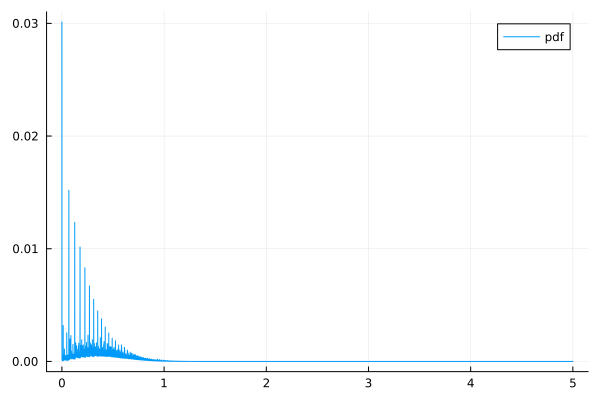

In [112]:
pdfA = compute_stationary_distribution(sol_2)
plot(sol_2.h.a_grid, sum(pdfA, dims = 2)[:, 1], label = "pdf")

Of course you can also plot the CDF.

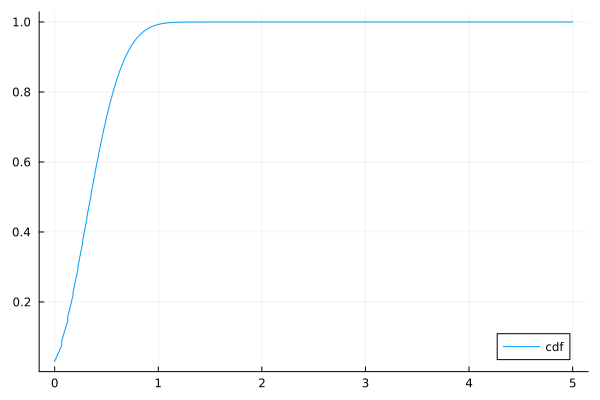

In [113]:
plot(sol_2.h.a_grid, cumsum(sum(pdfA, dims = 2)[:, 1]), label = "cdf")

We can also compute the aggregate asset supply under the invariant distribution, which is simply:

In [114]:
# function for computing A under the invariant distribution
function compute_A(sol, pdf)
    a = similar(sol.v)
    a = sol.h.a_grid[sol.pol]
    return a⋅pdf 
end

compute_A (generic function with 1 method)

In [115]:
@show compute_A(sol_2, pdfA)

compute_A(sol_2, pdfA) = 0.369596584657044


0.369596584657044

#### The capital demand and supply curve

Since the aggregate labor supply $L$ is a constant as we have argued, the only equilibrium object that has to been determined endogenously is the market clearing capital (or asset). Now, the equilibrium interest rate $R = AαK^{α - 1} L^{1 - α} + 1 - δ$ is a one-to-one function of $K$. The inverse function $K(R)$ gives the capital demand curve, which is continuous and downward sloping. From the household problem, given each R, we can endogenously solve out the asset supply curve with the invariant distribution of household, which will be continuous and upward sloping. I denote the supply as $A(R)$. The unique intersection of $K(R)$ and $A(R)$ gives out the equilibrium capital and the corresponding interest rate.

The following function solves out the aggregate asset supply and capital demand over a grid of possible equilibrium interest rate $R$.

In [116]:
function K_demand_supply(h_GE; R_grids = range(0.95, 1.0/h_GE.β, 100), K_demand = similar(R_grids), A_supply = similar(R_grids), w_grids = similar(R_grids))
    (; a_grid, l, β, P, A, α, δ) = h_GE
    L = compute_L(P, l)
    # get the demand function
    K_demand  = @. ((R_grids  - 1 + δ)/(A * α  * L^(1 - α)))^(1/(α - 1))

    # equilibrium wages
    w_grids = @. A^(1/(1-α)) * (1 - α) * α^(α/(1 - α)) * (R_grids - 1 + δ)^(α/(1-α))
    # get the supply function (use the original VFI function)
    for i in eachindex(R_grids)
        sol = solve_household(h_GE, R = R_grids[i], w = w_grids[i])
        pdf = compute_stationary_distribution(sol)
        A_supply[i] = compute_A(sol, pdf)
    end
    return R_grids, K_demand, A_supply
end

R_grids, K_demand, A_supply = K_demand_supply(h_GE)


(0.95:0.004834054834054834:1.4285714285714286, [2.60652179549653, 2.5627940773789417, 2.5200152434997873, 2.478160077939212, 2.437204156566178, 2.397123818392531, 2.357896138098968, 2.319498899679491, 2.281910571153586, 2.245110280297914  …  0.7417193283888633, 0.7331551913712457, 0.7247191599818888, 0.7164088838744119, 0.7082220637337434, 0.7001564499975564, 0.6922098416139814, 0.6843800848344437, 0.6766650720405278, 0.6690627406037875], [0.02021733601917217, 0.02225411112707327, 0.024272027202561518, 0.02630871087100185, 0.028363202034400424, 0.03050970239871654, 0.03256419356390573, 0.03473583929991254, 0.03703595502577462, 0.039282465389271895  …  1.8283391974074534, 2.025767366906268, 2.2409799736927156, 2.46655872048356, 2.693734454901377, 2.9155084789630434, 3.1239109235495204, 3.3164715573265564, 3.490405521495349, 3.6463635452372722])

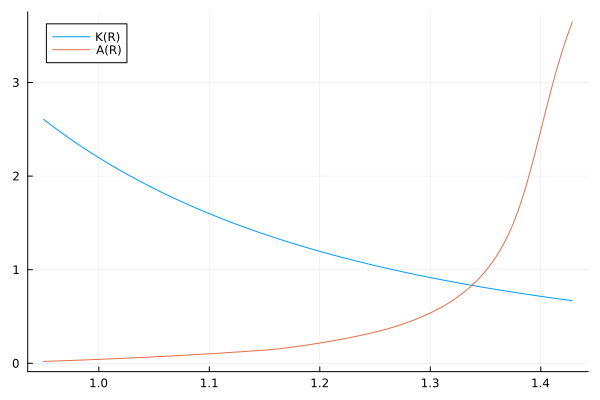

In [117]:
function K_plot(K_demand, A_supply; R_grids = range(0.95, 1.0/h_GE.β, 100))
    plot(R_grids, K_demand, label = "K(R)")
    plot!(R_grids, A_supply, label = "A(R)")
end

K_plot(K_demand, A_supply)

We can look at when $A(R)$ first exceeds $K(R)$ to have a guess on the equilibrium capital and interest rate.

In [118]:
function find_first(K_demand, A_supply)
    idx = 0
    for i in eachindex(K_demand)
        if A_supply[i] > K_demand[i]
            idx = i
            break
        end
    end
    return idx
end

i = find_first(K_demand, A_supply)

K1 = K_demand[i]
K2 = K_demand[i - 1]
R1 = R_grids[i - 1]
R2 = R_grids[i]

print("The equilibrium capital is between $K1 and $K2. The equilibrium interest rate is between $R1 and $R2.")

The equilibrium capital is between 0.8249761448802857 and 0.8349628271744827. The equilibrium interest rate is between 1.3367243867243868 and 1.3415584415584416.

#### Solving the stationary competitive equilibrium

Now we have everything ready to compute the stationary competitive equilibrium. 

The algorithm goes as follows:

* Start from a given $K_0$
* For each $K_t$ and obtain $R$ and $w$
* Solve the household problem given $R$ and $w$
* Compute invariant distribution $\lambda(a, s)$
* Get $A \equiv \sum_{s \in S} \sum_{a \in A} \lambda(a,s) g(a,s)$.
* Guess $K_{t+1} = ϵ A + (1 - ϵ) K_t$. Go back to the second step and iterate until convergence.


In [119]:
compute_A(sol_2, pdfA)

0.369596584657044

In [124]:
function compute_stationary_equilibrium(h_GE; K0 = 0.7556, tol = 1e-3, iterate = 0, ϵ = 0.1)
    sol = solve_household_GE(h_GE, K = K0)
    pdf = compute_stationary_distribution(sol)
    A = compute_A(sol, pdf)

    K = K0
    K1 = ϵ * A + (1 - ϵ) *  K

    while true 
        distance = zero(eltype(K))
        sol = solve_household_GE(h_GE, K = K)
        pdf = compute_stationary_distribution(sol)
        A = compute_A(sol, pdf)
        K1 = ϵ * A + (1 - ϵ) * K # for speed

        distance = abs(K1 - K)
        (distance < tol || iterate == 400) && break
        iterate += 1
        K = copy(K1)
    end 
    return (K_rce = K, sol_rce = sol, iterate = iterate) 
end

compute_stationary_equilibrium (generic function with 1 method)

***Warning***: this can get slow as the parameter values are casually set and the algorithms are not optimized. If you play around with the parameters you might notice that often times it doesn't converge.

The reason that it gets hard, after a talk with my friend Yuta Maeda, is that the asset supply curve is very steep around the equilibrium. Recall that originally when setting up the grid for asset, we have 10000 grids for 

In [125]:
@time begin
    sol_GE = compute_stationary_equilibrium(h_GE)
end

  1.259276 seconds (22.41 k allocations: 10.987 MiB, 0.28% gc time, 1.56% compilation time)


(K_rce = 0.7043197273107975, sol_rce = (v = [-10.313447004231326 -7.618718888437671; -10.302014245223877 -7.614847928801564; … ; -1.3933333536422459 -1.3420544555698646; -1.3932147578253677 -1.3419444459274648], pol = [1 139; 1 140; … ; 9691 10000; 9692 10000], h = Household_GE{Matrix{Float64}, Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}(0.7, 2.0, 0.0, [0.5 0.5; 0.2 0.8], [2.0, 4.0], 0.0, 5.0, 10000, 0.0:0.0005000500050005:5.0, 1.25, 0.7, 1.0), R = 1.4067309988398975, w = 0.12384854918781973), iterate = 6)

In [122]:
# equilibrium interest rate
@show sol_GE.sol_rce.R

sol_GE.sol_rce.R = 1.425584074679159


1.425584074679159

In [123]:
# equilibrium wage 
@show sol_GE.sol_rce.w

sol_GE.sol_rce.w = 0.12006048940900721


0.12006048940900721

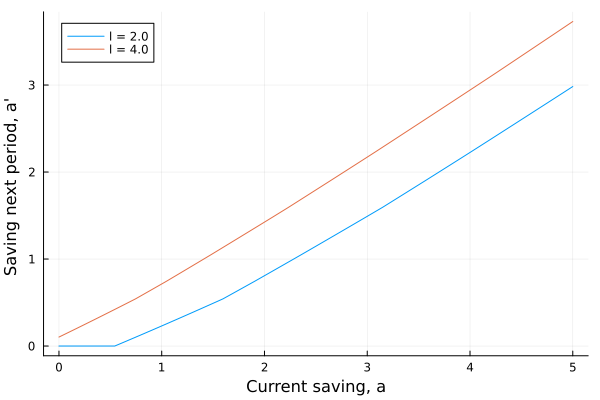

In [179]:
function do_pol_plot_GE(sol_1)

    (; pol, h)= sol_1 

    p1 = Plots.plot(xlabel = "Current saving, a", ylabel = "Saving next period, a' ")
    for s in eachindex(h.l)
        temp = h.l[s]
        yvals = [[h.a_grid[pol[i, s]] for i in eachindex(h.a_grid)]]
        plot!(p1, sol_1.h.a_grid, yvals, label = "l = $temp")
    end
    
    return p1
end


do_pol_plot_GE(sol_GE.sol_rce)

### Transition dynamics for incomplete market

Economists are often interested in the short-run response of agents given an unexpected one-time shock (often referred to as the MIT shock). Now we have the tools to compute the stationary competitive equilibrium. However as you can see, even under stationarity, this is a very complicated process.

Assuming that households have perfect foresight over prices, this implies that household needs to know everyone else's state today (knowing the distribution is sufficient) to infer the prices next period. In dynamic programming term, you need the whole distribution as an additional state variable. Note that the distribution is of very high dimensionality (here $A \times s$), taking conditional expectation over this gigantic object is merely impossible.

I put a simpler exercise based on a variation of the Hugget model in the exercise (adopted from Manuel's problem set). One should be able to figure it out with the hints provided. I will provide a solution if you send me an email.

[Krussel Smith (1998)](http://www.econ.yale.edu/smith/250034.pdf) is a very important contribution to the computation technique of the model. They are able to show that first order approximations over prices provide very accurate results because the policy function is close to linear when $a$ is not very low. 

The latest development of the field is the [sequence Jacobian](http://web.stanford.edu/~aauclert/sequence_space_jacobian.pdf). Auclert et al. provides a computation technique that is crazy fast.





### Conclusion

Incomplete market models are the workhorse models in modern Macroeconomic research, particularly in Macro-Labor and Macro-Finance. Knowing how to compute the basic model is of vital importance. In this lecture I started with the partial equilibrium version of the heteorgeneous household saving model (known as a Bewley/Hugget model), then I built towards the general equilibrium version of the model (known as an Aiyagari model). This lecture serves more as an introduction to allude readers to dive deeper themselves.